In [1]:
import os
import cv2
import glob 
# used to find all the pathnames matching a specified pattern
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128

In [3]:

import tarfile
file = tarfile.open('../input/brats-2021-task1/BraTS2021_Training_Data.tar')

file.extractall('./BraTS2021_Training_Data')
file.close()


In [4]:
file = tarfile.open('../input/brats-2021-task1/BraTS2021_00621.tar')

file.extractall('./sample_img')
file.close()

nSample = os.listdir('./sample_img')
nSample


['BraTS2021_00621_t2.nii.gz',
 'BraTS2021_00621_t1ce.nii.gz',
 'BraTS2021_00621_flair.nii.gz',
 'BraTS2021_00621_seg.nii.gz',
 'BraTS2021_00621_t1.nii.gz']

In [5]:
TRAIN_DATASET_PATH = 'C:/Users/srini/Downloads/archive (1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

In [6]:
nSample = os.listdir(TRAIN_DATASET_PATH + 'BraTS2021_01261')
nSample

['BraTS2021_01261_t1.nii.gz',
 'BraTS2021_01261_flair.nii.gz',
 'BraTS2021_01261_t1ce.nii.gz',
 'BraTS2021_01261_seg.nii.gz',
 'BraTS2021_01261_t2.nii.gz']

In [7]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_flair.nii.gz').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t1.nii.gz').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t1ce.nii.gz').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t2.nii.gz').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_seg.nii.gz').get_fdata()

In [8]:
def check_nifti(file_path):
    try:
        img = nib.load(file_path)
        # Additional checks if needed
        return True
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return False

data_folder = 'path_to_extracted_data'
damaged_files = []

for root, dirs, files in os.walk(data_folder):
    for file in files:
        file_path = os.path.join(root, file)
        if file_path.endswith('.nii') or file_path.endswith('.nii.gz'):
            if not check_nifti(file_path):
                damaged_files.append(file_path)

if damaged_files:
    print("Damaged files:")
    for damaged_file in damaged_files:
        print(damaged_file)
else:
    print("No damaged files found.")

No damaged files found.


In [9]:
import os
import nibabel as nib
import tarfile
import numpy as np

# Extract the tar file
tar_file_path = '../input/brats-2021-task1/BraTS2021_00621.tar'
extracted_folder = './sample_img'

with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall(extracted_folder)

# Specify the paths
data_folder = extracted_folder
output_folder = './preprocessed_data'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

def load_nifti(file_path):
    img = nib.load(file_path)
    return img

def save_nifti(img, save_path):
    nib.save(img, save_path)

def preprocess_nifti(img):
    # Example preprocessing: normalize intensity values
    data = img.get_fdata()
    
#     [[[[[normalize]]]]]
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    img = nib.Nifti1Image(data, img.affine)
    return img

def process_files(data_folder, output_folder):
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            file_path = os.path.join(root, file)
            if file_path.endswith('.nii') or file_path.endswith('.nii.gz'):
                try:
                    img = load_nifti(file_path)
                    preprocessed_img = preprocess_nifti(img)
                    
                    # Save the preprocessed image
                    output_path = os.path.join(output_folder, file)
                    save_nifti(preprocessed_img, output_path)
                    
                    print(f"Processed: {file_path}")
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")

# Perform preprocessing
process_files(data_folder, output_folder)


Processed: ./sample_img/BraTS2021_00621_t2.nii.gz
Processed: ./sample_img/BraTS2021_00621_t1ce.nii.gz
Processed: ./sample_img/BraTS2021_00621_flair.nii.gz
Processed: ./sample_img/BraTS2021_00621_seg.nii.gz
Processed: ./sample_img/BraTS2021_00621_t1.nii.gz


In [10]:
from skimage.transform import resize

def preprocess_nifti(img, target_shape=(256, 256, 128)):
    data = img.get_fdata()
    data_resized = resize(data, target_shape, anti_aliasing=True)
    img_resized = nib.Nifti1Image(data_resized, img.affine)
    return img_resized

In [12]:
pip install elasticdeform


  Preparing metadata (setup.py) ... - \ done
  Created wheel for elasticdeform: filename=elasticdeform-0.5.0-cp37-cp37m-linux_x86_64.whl size=94814 sha256=ea4dfa4ba221bc328160d4dcfc28b9a4099fe4092292af51a5faa02954b8de50
  Stored in directory: /root/.cache/pip/wheels/97/77/b3/c76931cdaf7131786a365712bc0c3efa0c12aad6c47c27598c
Successfully built elasticdeform
Note: you may need to restart the kernel to use updated packages.


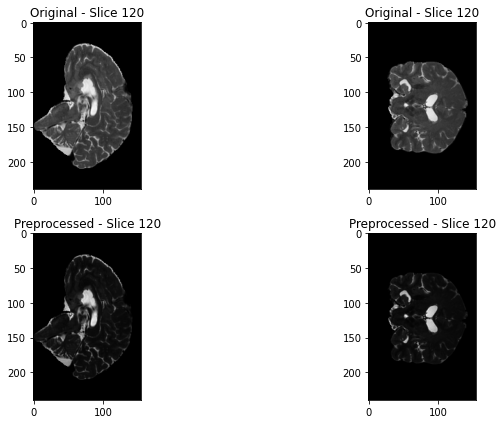

Processed: ./sample_img/BraTS2021_00621_t2.nii.gz


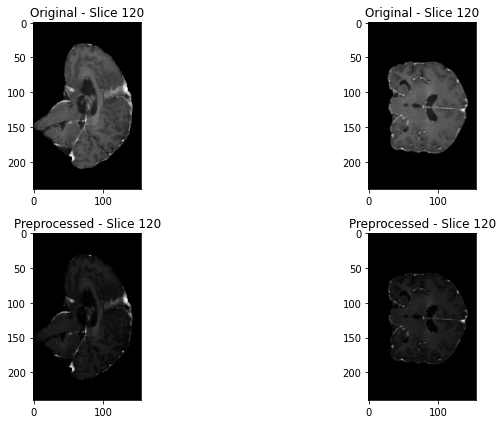

Processed: ./sample_img/BraTS2021_00621_t1ce.nii.gz


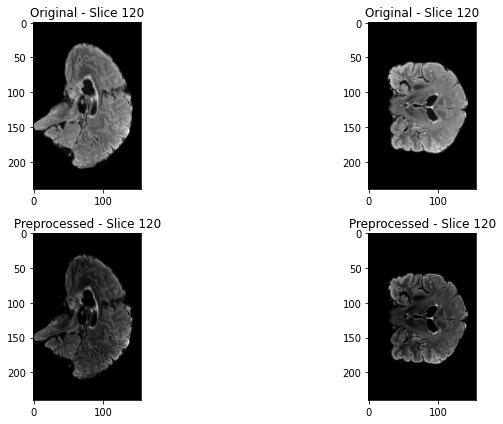

Processed: ./sample_img/BraTS2021_00621_flair.nii.gz


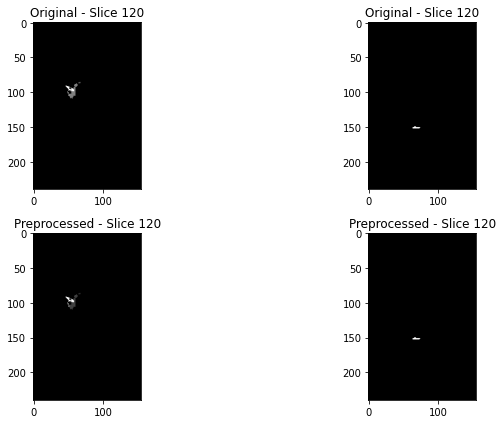

Processed: ./sample_img/BraTS2021_00621_seg.nii.gz


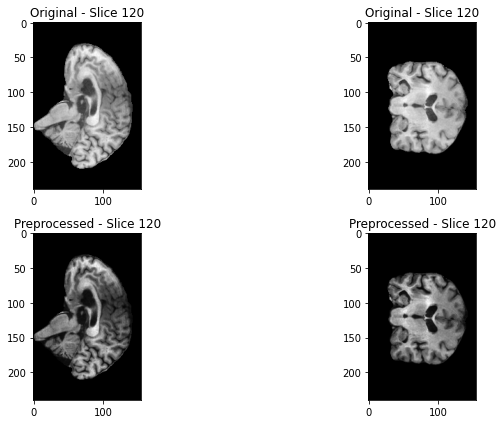

Processed: ./sample_img/BraTS2021_00621_t1.nii.gz


In [13]:
import os
import nibabel as nib
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt

def preprocess_nifti(img, brightness_factor= 2):
    data = img.get_fdata()

    # Brightness adjustment
    data_adjusted = exposure.adjust_gamma(data, gamma=brightness_factor)

    img_preprocessed = nib.Nifti1Image(data_adjusted, img.affine)
    return img_preprocessed

def show_slices(data_before, data_after):
    # Display slices from the original and preprocessed data
    slice_index = data_before.shape[0] // 2  # Adjust as needed

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    plt.imshow(data_before[slice_index, :, :], cmap='gray')
    plt.title('Original - Slice {}'.format(slice_index))

    plt.subplot(2, 2, 2)
    plt.imshow(data_before[:, slice_index, :], cmap='gray')
    plt.title('Original - Slice {}'.format(slice_index))

    plt.subplot(2, 2, 3)
    plt.imshow(data_after[slice_index, :, :], cmap='gray')
    plt.title('Preprocessed - Slice {}'.format(slice_index))

    plt.subplot(2, 2, 4)
    plt.imshow(data_after[:, slice_index, :], cmap='gray')
    plt.title('Preprocessed - Slice {}'.format(slice_index))

    plt.tight_layout()
    plt.show()

# Path to the folder containing the NIfTI files
data_folder = './sample_img/'

# Output folder for preprocessed data
output_folder = './preprocessed_data/'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Process each file in the data folder
for root, dirs, files in os.walk(data_folder):
    for file in files:
        file_path = os.path.join(root, file)
        if file_path.endswith('.nii') or file_path.endswith('.nii.gz'):
            try:
                # Load the NIfTI image
                img = nib.load(file_path)

                # Extract the data before preprocessing
                data_before = img.get_fdata()

                # Preprocess the image (brightness adjustment only)
                img_preprocessed = preprocess_nifti(img)

                # Extract the data after preprocessing
                data_after = img_preprocessed.get_fdata()

                # Show slices
                show_slices(data_before, data_after)

                # Save the preprocessed image
                output_path = os.path.join(output_folder, file)
                nib.save(img_preprocessed, output_path)

                print(f"Processed: {file_path}")
            except Exception as e:
                print(f"Error processing {file_path}: {str(e)}")


# show sample of image

Text(0.5, 1.0, 'Mask')

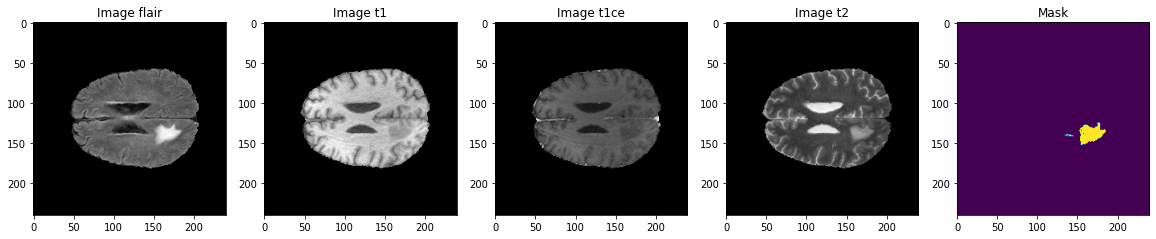

In [14]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

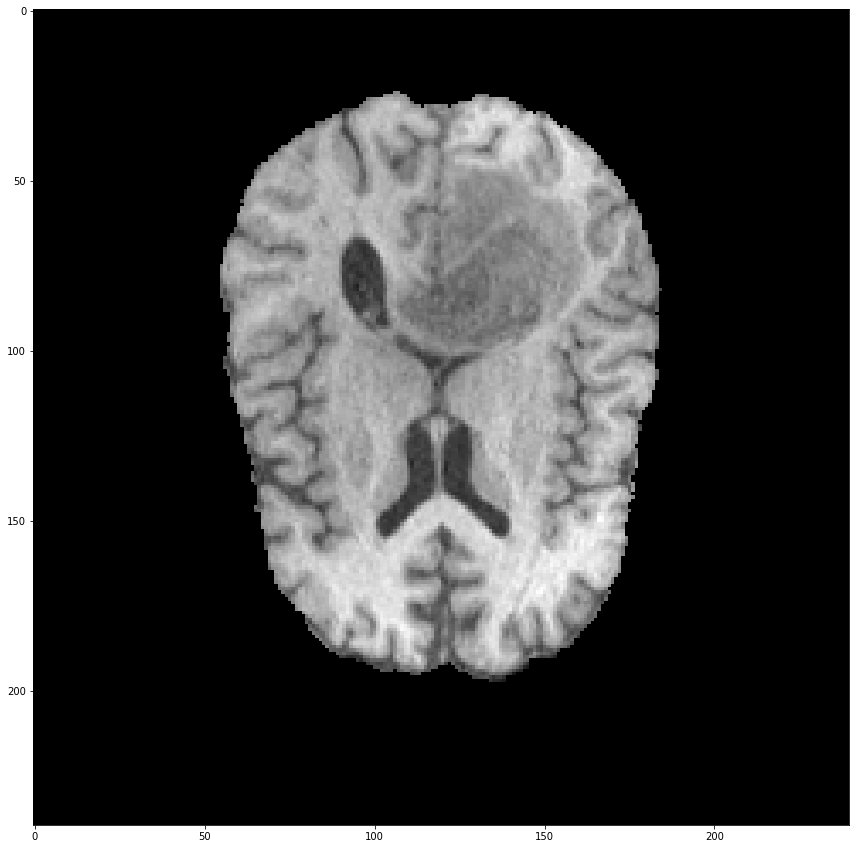

In [16]:
from skimage.transform import rotate, resize
from skimage.util import montage
import matplotlib.pyplot as plt

# Assuming test_image_t1 is a 3D volume
# Select a slice for display
slice_index = test_image_t1.shape[2] // 2

# Rotate and resize the image
rotated_resized_image = resize(rotate(test_image_t1[:,:,slice_index], angle=90), (test_image_t1.shape[0], test_image_t1.shape[1]))

# Display the rotated and resized image
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(rotated_resized_image, cmap='gray')
plt.show()

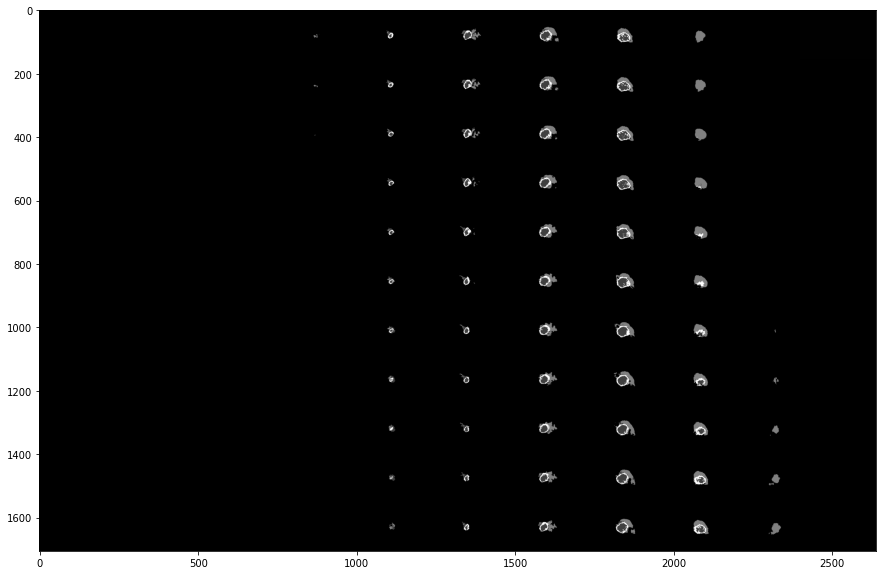

In [17]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

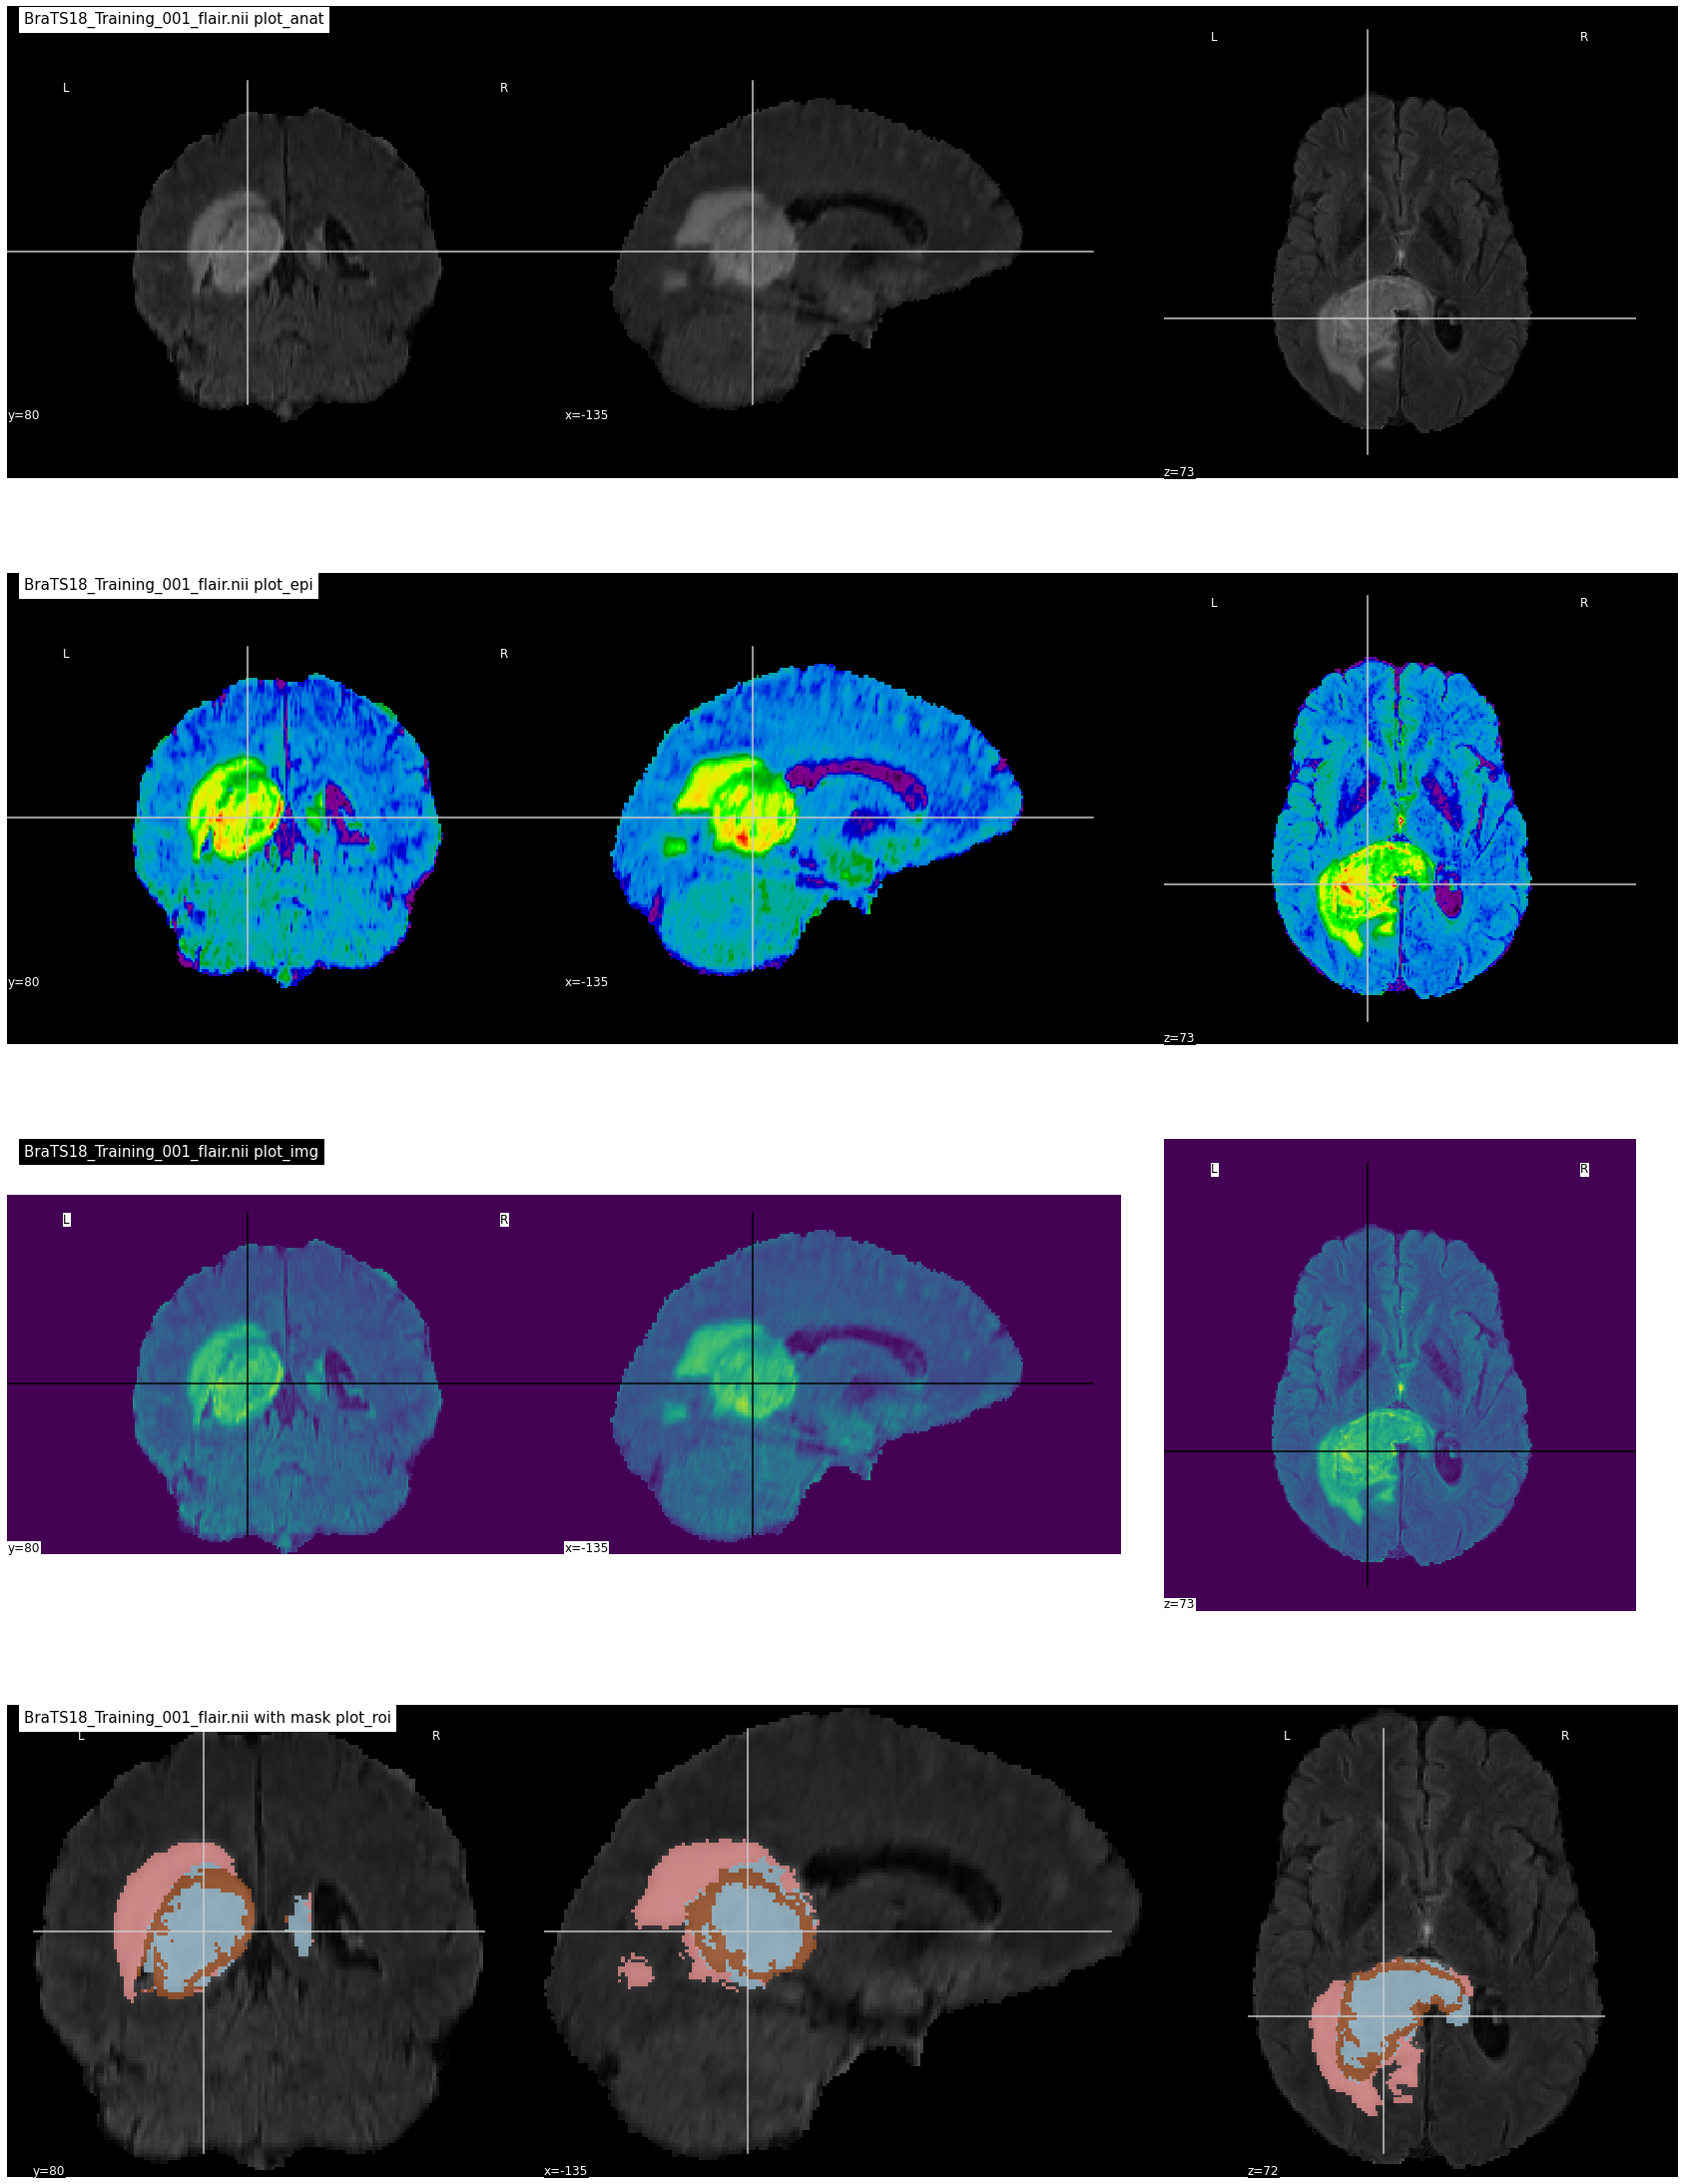

In [18]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_flair.nii.gz')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_seg.nii.gz')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))

nlplt.plot_anat(niimg,
                title='BraTS18_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS18_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS18_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS18_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [19]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
            
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# These functions are used for evaluating the performance of a segmentation model on three different classes
# in medical imaging (presumably related to brain tumor segmentation).
# Input Parameters:
# y_true: The ground truth segmentation mask for the edema class.
# y_pred: The predicted segmentation mask for the edema class.
# epsilon: A small constant to avoid division by zero.

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [20]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )


In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 608         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [23]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [24]:
train_and_test_ids[0] 

'BraTS2021_00379'

In [25]:
train_ids[0]

'BraTS2021_01218'

In [26]:
test_ids[0]

'BraTS2021_01537'

In [27]:
TRAIN_DATASET_PATH

'./BraTS2021_Training_Data/'

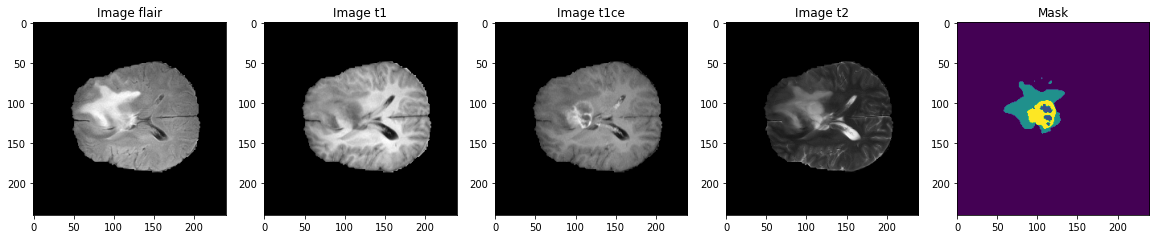

In [28]:
case_index = 0
case_name = test_ids[case_index]

test_image_flair = nib.load(os.path.join(TRAIN_DATASET_PATH, case_name, f'{case_name}_flair.nii.gz')).get_fdata()
test_image_t1 = nib.load(os.path.join(TRAIN_DATASET_PATH, case_name, f'{case_name}_t1.nii.gz')).get_fdata()
test_image_t1ce = nib.load(os.path.join(TRAIN_DATASET_PATH, case_name, f'{case_name}_t1ce.nii.gz')).get_fdata()
test_image_t2 = nib.load(os.path.join(TRAIN_DATASET_PATH, case_name, f'{case_name}_t2.nii.gz')).get_fdata()
test_mask = nib.load(os.path.join(TRAIN_DATASET_PATH, case_name, f'{case_name}_seg.nii.gz')).get_fdata()

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
slice_w = test_image_flair.shape[2] // 2

axes[0].imshow(test_image_flair[:, :, slice_w], cmap='gray')
axes[0].set_title('Image flair')

axes[1].imshow(test_image_t1[:, :, slice_w], cmap='gray')
axes[1].set_title('Image t1')

axes[2].imshow(test_image_t1ce[:, :, slice_w], cmap='gray')
axes[2].set_title('Image t1ce')

axes[3].imshow(test_image_t2[:, :, slice_w], cmap='gray')
axes[3].set_title('Image t2')

axes[4].imshow(test_mask[:, :, slice_w])
axes[4].set_title('Mask')

plt.show()


In [29]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [30]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

850
251
150


In [31]:
test_ids[0:10]

['BraTS2021_01537',
 'BraTS2021_00109',
 'BraTS2021_01492',
 'BraTS2021_01141',
 'BraTS2021_01295',
 'BraTS2021_00545',
 'BraTS2021_00834',
 'BraTS2021_00404',
 'BraTS2021_01257',
 'BraTS2021_00298']

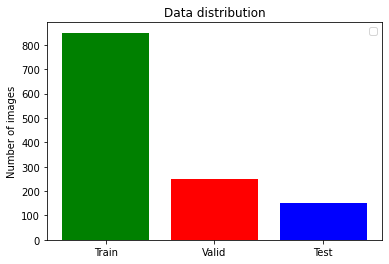

In [32]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig('data2018.png')
    plt.show()
    
showDataLayout()

In [33]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath="3D-UNet-2018-weights-improvement-{epoch:02d}-{val_accuracy:.3f}.hdf5" 

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

csv_logger = CSVLogger('training_2021_2D_UNet.log')

history =  model.fit(training_generator,
                    epochs=12,
                    steps_per_epoch=len(train_ids),
                    callbacks= [checkpoint, csv_logger, early_stop],
                    validation_data = valid_generator
                    )  

# Metrics: Various metrics are reported during training and validation to assess the model's performance. These include:

# Loss: A measure of how well the model is performing. It represents an error value that the model is trying to minimize during training.
# Accuracy: The proportion of correctly classified samples.
# Mean Intersection over Union (mean_io_u): A metric used for image segmentation tasks, measuring the overlap between predicted and true segmentation masks.
# Dice Coefficient (dice_coef): Another metric for segmentation tasks, measuring the similarity between predicted and true masks.
# Precision, Sensitivity, Specificity: These are commonly used metrics in binary classification tasks. Precision is the ratio of true positives to the sum of true positives and false positives. Sensitivity (recall) is the ratio of true positives to the sum of true positives and false negatives. Specificity is the ratio of true negatives to the sum of true negatives and false positives.
# Dice Coefficients for Necrotic, Edema, Enhancing: Specific dice coefficients for different classes in the segmentation task.
# This is common in medical image segmentation where different regions of interest are segmented separately.
# Validation Metrics: These are metrics evaluated on a separate dataset not used for training. 
# They give an indication of how well the model generalizes to new, unseen data.

Epoch 1/12
850/850 [==============================] - 515s 589ms/step - loss: 0.0877 - accuracy: 0.9832 - mean_io_u: 0.6660 - dice_coef: 0.2789 - precision: 0.9830 - sensitivity: 0.9786 - specificity: 0.9948 - dice_coef_necrotic: 0.0605 - dice_coef_edema: 0.1509 - dice_coef_enhancing: 0.0852 - val_loss: 0.0589 - val_accuracy: 0.9837 - val_mean_io_u: 0.7691 - val_dice_coef: 0.3009 - val_precision: 0.9839 - val_sensitivity: 0.9835 - val_specificity: 0.9946 - val_dice_coef_necrotic: 0.1121 - val_dice_coef_edema: 0.2488 - val_dice_coef_enhancing: 0.1723

Epoch 00001: val_accuracy improved from -inf to 0.98368, saving model to 3D-UNet-2018-weights-improvement-01-0.984.hdf5
Epoch 2/12
850/850 [==============================] - 495s 582ms/step - loss: 0.0559 - accuracy: 0.9841 - mean_io_u: 0.5671 - dice_coef: 0.3303 - precision: 0.9875 - sensitivity: 0.9816 - specificity: 0.9958 - dice_coef_necrotic: 0.1357 - dice_coef_edema: 0.2504 - dice_coef_enhancing: 0.2638 - val_loss: 0.0425 - val_accur

In [34]:
model.save("model_2021_2D_UNet.h5")

# "model_2021_2D_UNet.h5": This is the filename for the saved model. 
#     [[[[[[The ".h5" extension indicates that the Hierarchical Data Format version 5 (HDF5)]]]]]]
# file format is used for saving the model. HDF5 is a file format and a set of tools for managing complex data,
#     commonly used in the scientific and engineering fields.

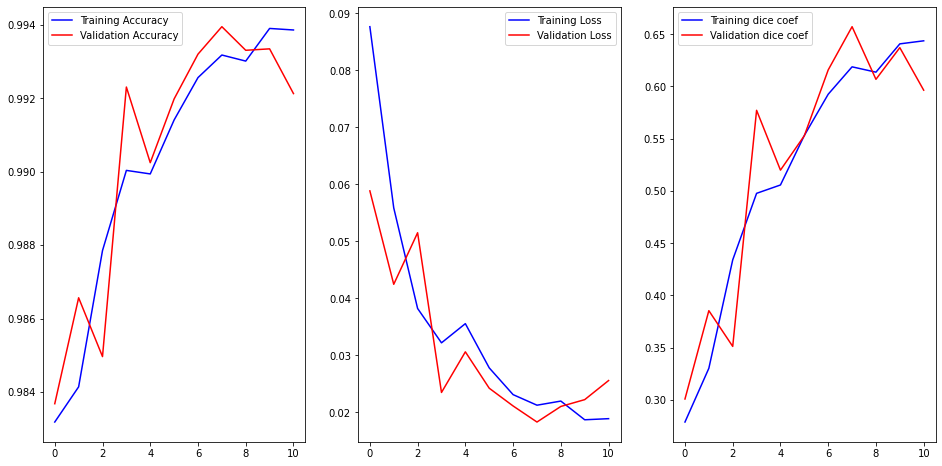

In [35]:
############ load trained model ################
model = tf.keras.models.load_model('model_2021_2D_UNet.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('training_2021_2D_UNet.log', sep=',', engine='python')

# hist=history.history

############### ########## ####### #######

# hist=history.history

acc = history['accuracy']
val_acc = history['val_accuracy']

epoch = range(len(acc))

loss = history['loss']
val_loss = history['val_loss']

train_dice = history['dice_coef']
val_dice = history['val_dice_coef']

f, ax = plt.subplots(1, 3, figsize=(16, 8))

ax[0].plot(epoch, acc, 'b', label='Training Accuracy')
ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch, loss, 'b', label='Training Loss')
ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch, train_dice, 'b', label='Training dice coef')
ax[2].plot(epoch, val_dice, 'r', label='Validation dice coef')
ax[2].legend()

plt.savefig('training_result_2018.png')
plt.show()


In [36]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)

In [37]:
import os

# Assuming TRAIN_DATASET_PATH is the path to your dataset directory
dataset_path = TRAIN_DATASET_PATH

# Get a list of files in the dataset directory
files = os.listdir(dataset_path)

# Extract case names from filenames
case_names = [file.split('_')[1] for file in files if 'flair.nii' in file]

# Print the case names
for case in case_names:
    print(case)


In [40]:
def showPredictsByCaseName(case_name, start_slice=60):
    path = os.path.join(TRAIN_DATASET_PATH, case_name)

    # Construct file paths
    seg_path = os.path.join(path, f'{case_name}_seg.nii.gz')
    flair_path = os.path.join(path, f'{case_name}_flair.nii.gz')

    # Print file paths
    print(f'Segmentation path: {seg_path}')
    print(f'Flair image path: {flair_path}')

    # Check if the segmentation file exists
    if not os.path.exists(seg_path):
        print(f"Segmentation file not found for case {case_name}")
        # Print the contents of the directory
        print(f"Contents of {path}: {os.listdir(path)}")
        return  # This 'return' is part of the function

    try:
        # Load segmentation ground truth
        gt = nib.load(seg_path).get_fdata()
    except FileNotFoundError:
        print(f"Error: Segmentation file not found for case {case_name}")
        return  # This 'return' is part of the function

    try:
        # Load original image
        origImage = nib.load(flair_path).get_fdata()
    except FileNotFoundError:
        print(f"Error: Original image file not found for case {case_name}")
        return  # This 'return' is part of the function

    # The rest of your code for prediction and visualization

# Example usage for case 'BraTS2021_00131'
showPredictsByCaseName(case_name='BraTS2021_00131')


Segmentation path: ./BraTS2021_Training_Data/BraTS2021_00131/BraTS2021_00131_seg.nii.gz
Flair image path: ./BraTS2021_Training_Data/BraTS2021_00131/BraTS2021_00131_flair.nii.gz


In [41]:
def showPredictsByCaseName(case_name, start_slice=60):
    path = os.path.join(TRAIN_DATASET_PATH, case_name)

    # Construct file paths
    seg_path = os.path.join(path, f'{case_name}_seg.nii.gz')  # Corrected file extension
    flair_path = os.path.join(path, f'{case_name}_flair.nii')

    # Print file paths
    print(f'Segmentation path: {seg_path}')
    print(f'Flair image path: {flair_path}')

    # Check if the segmentation file exists
    if not os.path.exists(seg_path):
        print(f"Segmentation file not found for case {case_name}")
        # Print the contents of the directory
        print(f"Contents of {path}: {os.listdir(path)}")
        return

    try:
        # Load segmentation ground truth
        gt = nib.load(seg_path).get_fdata()
    except FileNotFoundError:
        print(f"Error: Segmentation file not found for case {case_name}")
        return

    try:
        # Load original image
        origImage = nib.load(flair_path).get_fdata()
    except FileNotFoundError:
        print(f"Error: Original image file not found for case {case_name}")
        return

    # Your existing code for prediction
    p = predictByPath(path, case_name)
    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    # Display images
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 7, figsize=(18, 50))

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),
                        cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].set_title('Original image flair')

    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].set_title('Ground truth')

    axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].set_title('All classes')

    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].set_title(f'{SEGMENT_CLASSES[1]} predicted')

    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].set_title(f'{SEGMENT_CLASSES[2]} predicted')

    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].set_title(f'{SEGMENT_CLASSES[3]} predicted')

    # Display the predicted mask overlay on the original image
    axarr[6].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),
                    cmap="gray", interpolation='none')
    axarr[6].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[6].set_title('Overlay: Prediction on Original Image')

    plt.savefig(f'Test_{case_name}.png')
    plt.show()

# Example usage for case 'BraTS2021_00131'
showPredictsByCaseName(case_name='BraTS2021_00131')


Segmentation path: ./BraTS2021_Training_Data/BraTS2021_00131/BraTS2021_00131_seg.nii.gz
Flair image path: ./BraTS2021_Training_Data/BraTS2021_00131/BraTS2021_00131_flair.nii
Error: Original image file not found for case BraTS2021_00131


Flair image path: ./BraTS2021_Training_Data/BraTS2021_00124/BraTS2021_00124_flair.nii.gz
4/4 [==============================] - 2s 120ms/step


<Figure size 1296x3600 with 0 Axes>

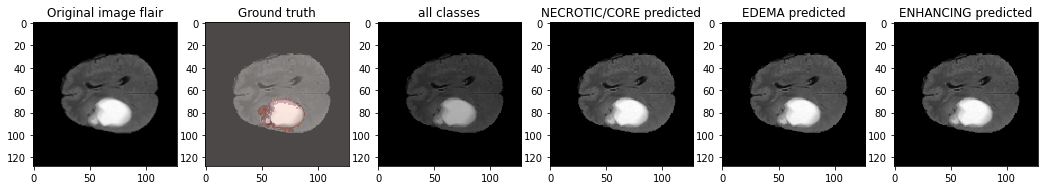

Flair image path: ./BraTS2021_Training_Data/BraTS2021_00054/BraTS2021_00054_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 1296x3600 with 0 Axes>

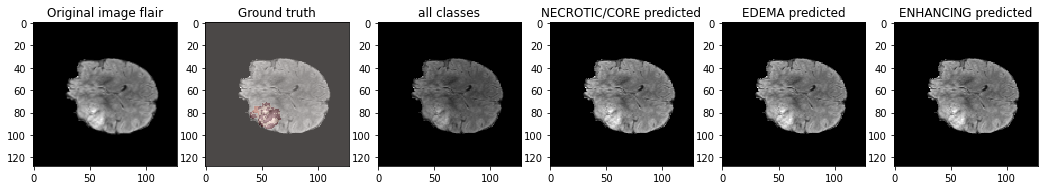

Flair image path: ./BraTS2021_Training_Data/BraTS2021_01172/BraTS2021_01172_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 1296x3600 with 0 Axes>

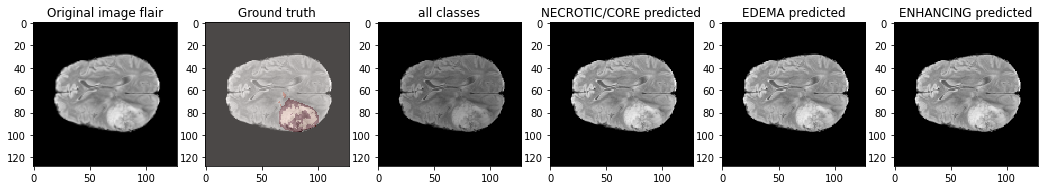

Flair image path: ./BraTS2021_Training_Data/BraTS2021_00191/BraTS2021_00191_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 1296x3600 with 0 Axes>

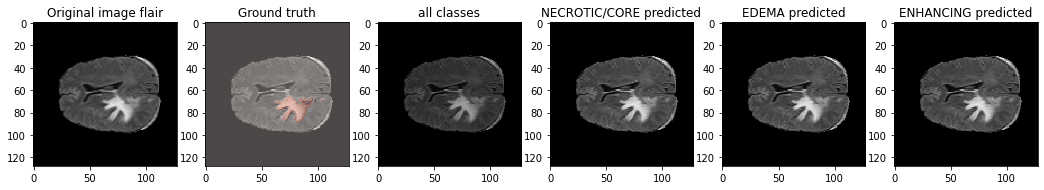

Flair image path: ./BraTS2021_Training_Data/BraTS2021_01342/BraTS2021_01342_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 1296x3600 with 0 Axes>

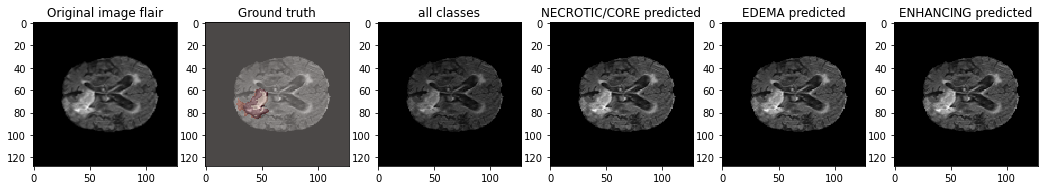

Flair image path: ./BraTS2021_Training_Data/BraTS2021_00097/BraTS2021_00097_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 1296x3600 with 0 Axes>

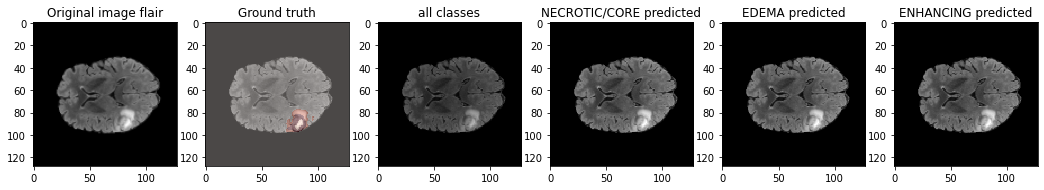

Flair image path: ./BraTS2021_Training_Data/BraTS2021_01625/BraTS2021_01625_flair.nii.gz
4/4 [==============================] - 0s 27ms/step


<Figure size 1296x3600 with 0 Axes>

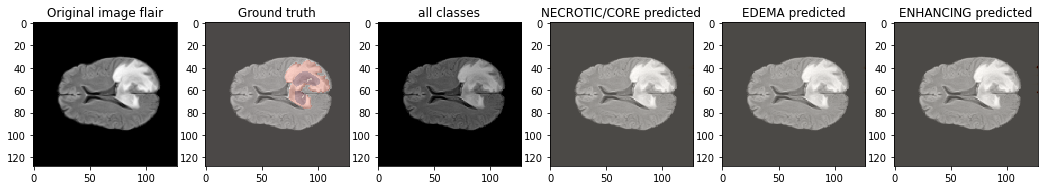

Flair image path: ./BraTS2021_Training_Data/BraTS2021_00451/BraTS2021_00451_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 1296x3600 with 0 Axes>

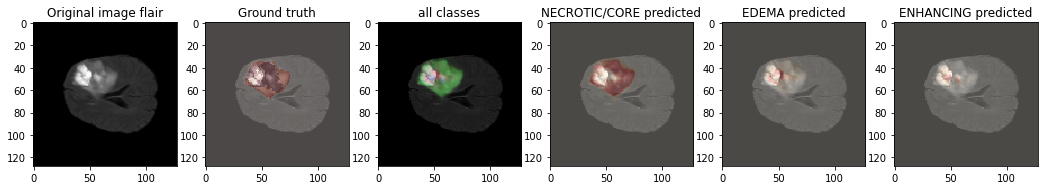

Flair image path: ./BraTS2021_Training_Data/BraTS2021_00336/BraTS2021_00336_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 1296x3600 with 0 Axes>

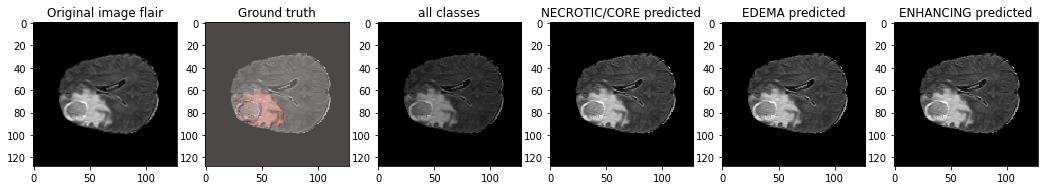

Flair image path: ./BraTS2021_Training_Data/BraTS2021_01446/BraTS2021_01446_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 1296x3600 with 0 Axes>

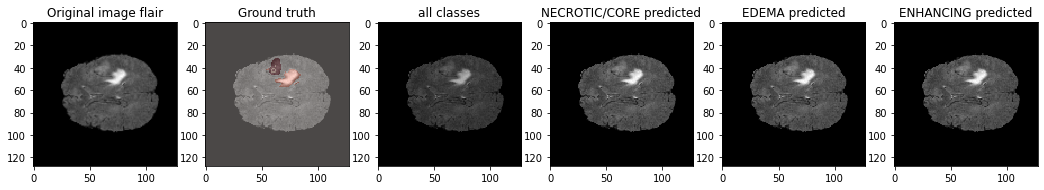

In [44]:
def predictByPath(case_path, case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path_flair = os.path.join(case_path, f'{case}_flair.nii.gz')
    print(f'Flair image path: {vol_path_flair}')

    try:
        flair = nib.load(vol_path_flair).get_fdata()
    except FileNotFoundError:
        print(f"Error: Flair image file not found for case {case}")
        return

    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    return model.predict(X / np.max(X), verbose=1)

def showPredictsById(case, start_slice=60):
    path = TRAIN_DATASET_PATH + case + '/'

    gt = nib.load(path + case + '_seg.nii.gz').get_fdata()
    origImage = nib.load(os.path.join(path, f'{case}_flair.nii.gz')).get_fdata()
    p = predictByPath(path, case)

    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),
                        cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.savefig(f'Test_{case}.png')
    plt.show()
# 'BraTS2021_00124',
#  'BraTS2021_00054',
#  'BraTS2021_01543',
#  'BraTS2021_00191',
#  'BraTS2021_01342',
#  'BraTS2021_00097',
#  'BraTS2021_01625',
#  'BraTS2021_00451',
#  'BraTS2021_00336',
#  'BraTS2021_01446'
# 
# Example usage for case 'BraTS2021_00131'
showPredictsById(case='BraTS2021_00124')
showPredictsById(case='BraTS2021_00054')
showPredictsById(case='BraTS2021_01172')
showPredictsById(case='BraTS2021_00191')
showPredictsById(case='BraTS2021_01342')
showPredictsById(case='BraTS2021_00097')
showPredictsById(case='BraTS2021_01625')
showPredictsById(case='BraTS2021_00451')
showPredictsById(case='BraTS2021_00336')
showPredictsById(case='BraTS2021_01446')

Flair image path: ./BraTS2021_Training_Data/BraTS2021_01295/BraTS2021_01295_flair.nii.gz
4/4 [==============================] - 0s 30ms/step


<Figure size 432x288 with 0 Axes>

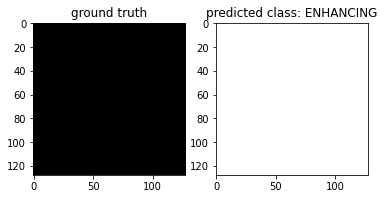

Flair image path: ./BraTS2021_Training_Data/BraTS2021_00545/BraTS2021_00545_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 432x288 with 0 Axes>

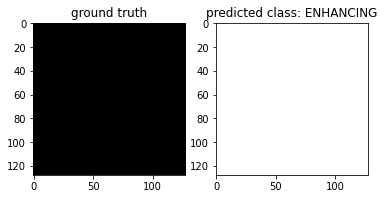

Flair image path: ./BraTS2021_Training_Data/BraTS2021_00834/BraTS2021_00834_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 432x288 with 0 Axes>

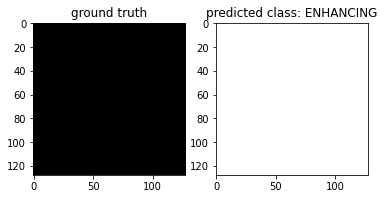

Flair image path: ./BraTS2021_Training_Data/BraTS2021_00404/BraTS2021_00404_flair.nii.gz
4/4 [==============================] - 0s 27ms/step


<Figure size 432x288 with 0 Axes>

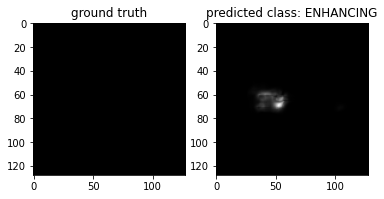

Flair image path: ./BraTS2021_Training_Data/BraTS2021_01257/BraTS2021_01257_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 432x288 with 0 Axes>

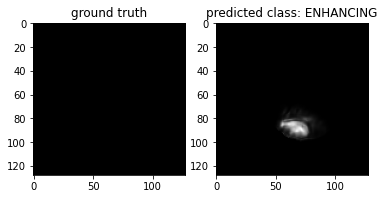

Flair image path: ./BraTS2021_Training_Data/BraTS2021_00298/BraTS2021_00298_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 432x288 with 0 Axes>

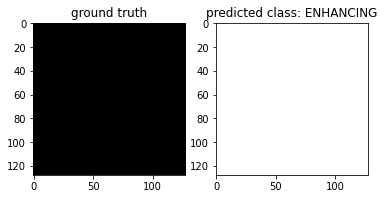

Flair image path: ./BraTS2021_Training_Data/BraTS2021_00693/BraTS2021_00693_flair.nii.gz
4/4 [==============================] - 0s 26ms/step


<Figure size 432x288 with 0 Axes>

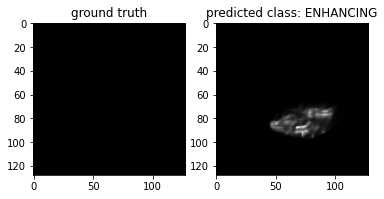

In [48]:
 
def visualize_prediction(case):
    path = os.path.join(TRAIN_DATASET_PATH, case)

    # Check if the segmentation file exists
    seg_path = os.path.join(path, f'{case}_seg.nii.gz')
    if not os.path.exists(seg_path):
        print(f"Segmentation file not found for case {case}")
        print(f"Contents of {path}: {os.listdir(path)}")
    else:
        gt = nib.load(seg_path).get_fdata()

        p = predictByPath(path, case)

        core = p[:, :, :, 1]
        edema = p[:, :, :, 2]
        enhancing = p[:, :, :, 3]

        i = 40  # slice at
        eval_class = 3  # 0: 'NOT tumor', 1: 'ENHANCING', 2: 'CORE', 3: 'WHOLE'

        gt[gt != eval_class] = 1  # use only one class for per class evaluation

        resized_gt = cv2.resize(gt[:, :, i + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

        plt.figure()
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(resized_gt, cmap="gray")
        axarr[0].title.set_text('ground truth')
        axarr[1].imshow(p[i, :, :, eval_class], cmap="gray")
        axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
        plt.show()

# Test for cases 4 to 10
for i in range(4, 11):
    case = test_ids[i]
    visualize_prediction(case)


In [49]:
csv_logger = CSVLogger('./evaluation_50.log')
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= [csv_logger])
# print("test loss, test acc:", results)

Evaluate on test data
150/150 [==============================] - 67s 436ms/step - loss: 0.0179 - accuracy: 0.9941 - mean_io_u_2: 0.8219 - dice_coef: 0.6639 - precision: 0.9943 - sensitivity: 0.9930 - specificity: 0.9981 - dice_coef_necrotic: 0.6411 - dice_coef_edema: 0.7489 - dice_coef_enhancing: 0.7885


In [50]:
# Print the evaluation results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])
print("Mean IoU:", results[2])

print("\nAdditional Metrics:")
print("Dice Coefficient:", results[3])
print("Precision:", results[4])
print("Sensitivity:", results[5])
print("Specificity:", results[6])
print("Dice Coefficient Necrotic:", results[7])
print("Dice Coefficient Edema:", results[8])
print("Dice Coefficient Enhancing:", results[9])


Test Loss: 0.017877815291285515
Test Accuracy: 0.9941461086273193
Mean IoU: 0.8219121098518372

Additional Metrics:
Dice Coefficient: 0.6639007329940796
Precision: 0.9942646026611328
Sensitivity: 0.9929519891738892
Specificity: 0.9980671405792236
Dice Coefficient Necrotic: 0.6411239504814148
Dice Coefficient Edema: 0.7489060163497925
Dice Coefficient Enhancing: 0.7885343432426453


In [51]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import CSVLogger
# from your_module import dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing

# Assuming you have a `test_generator` for your test data

csv_logger = CSVLogger('./evaluation_50.log')

# Assuming you have already defined your model
model = tf.keras.models.load_model(
    'model_2021_2D_UNet.h5', 
    custom_objects={ 
        'accuracy': tf.keras.metrics.MeanIoU(num_classes=4),
        'dice_coef': dice_coef,
        'precision': precision,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'dice_coef_necrotic': dice_coef_necrotic,
        'dice_coef_edema': dice_coef_edema,
        'dice_coef_enhancing': dice_coef_enhancing
    },
    compile=False
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(learning_rate=0.01),  # Change to your desired learning rate
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks=[csv_logger])

# Print the evaluation results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])
print("Mean IoU:", results[2])

# Print additional metrics if available
if len(results) > 3:
    print("Dice Coefficient:", results[3])
    print("Precision:", results[4])
    print("Sensitivity:", results[5])
    print("Specificity:", results[6])
    print("Dice Coefficient Necrotic:", results[7])
    print("Dice Coefficient Edema:", results[8])
    print("Dice Coefficient Enhancing:", results[9])


Evaluate on test data
150/150 [==============================] - 67s 438ms/step - loss: 0.0179 - accuracy: 0.9941 - mean_io_u_4: 0.8219 - dice_coef: 0.6639 - precision: 0.9943 - sensitivity: 0.9930 - specificity: 0.9981 - dice_coef_necrotic: 0.6411 - dice_coef_edema: 0.7489 - dice_coef_enhancing: 0.7885
Test Loss: 0.017877811565995216
Test Accuracy: 0.9941456913948059
Mean IoU: 0.8219120502471924
Dice Coefficient: 0.6639009714126587
Precision: 0.994264543056488
Sensitivity: 0.9929520487785339
Specificity: 0.9980672001838684
Dice Coefficient Necrotic: 0.6411240100860596
Dice Coefficient Edema: 0.7489058375358582
Dice Coefficient Enhancing: 0.78853440284729
